<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

**Install packages**

In [ ]:
!git clone https://github.com/maudl3116/CondSigKME.git

In [1]:
%cd CondSigKME

/content/CondSigKME


In [ ]:
!pip install -r requirements.txt

In [ ]:
!pip install git+https://github.com/maudl3116/sigkernel.git

**Generate data**

In [ ]:
%cd n_vcn_utils

In [ ]:
!sh exp1.sh

In [ ]:
%cd ../

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from n_vcn_utils.utils import load_data
from src.SigKPC.pcskeleton import skeleton
import pickle 

**Define utilities** 

In [5]:
def get_gt_graph(path): 
    graph = pickle.load(open(path,'rb'))
    return graph[0][0][:,0].astype(np.int)


def pred_graph(pval,alpha=0.6,nball=5):
    edge = np.zeros(nball*(nball-1)//2)
    cnt = 0
    for i in range(nball):
        for j in range(i):
            if pval[i,j]<alpha:
                edge[cnt]=0
            else:
                edge[cnt]=1
            cnt+=1
    return edge.astype(int)

**Run experiment**

In [6]:
nball = 5

In [ ]:
ground_truth = []
hsics = []
for repeat in range(1,16):
    for i in range(5):
        name_paths = 'n_vcn_utils/data/exp1/{0}_Ball/{1}.obj'.format(repeat,i)
        name_graph = 'n_vcn_utils/data/exp1/{0}_Ball/graph_{1}.obj'.format(repeat,i)

        # get the distribution
        distri = pickle.load(open(name_paths,'rb'))  # (n_ball, i, T, D) with D=4
        
        # get ground truth graph 
        graph_gt = get_gt_graph(name_graph)
        
        # run causal discovery
        res = skeleton(distri[:,:,:,:2]*0.01, alpha=0.6, test= False, p=nball, maxi=1, fixedGaps=None, eps=0.01, dyadic_order=2, static='rbf', sigma=10.)
        ground_truth.append(graph_gt)
        hsics.append(res[2].copy())
        # pval = res[2].copy()
        # graph_pred = pred_graph(pval,alpha=0.6,nball=nball)
        # print('correct fraction', np.mean(graph_pred.astype(int)==graph_gt))

In [8]:
ground_truth, hsics = pickle.load(open('../drive/MyDrive/exp1_results.obj','rb'))

In [11]:
N = 50 # number of alphas to test
P = 5 # number of points in the function 
alphas_cv = np.linspace(0.2,2.5,N)

N_rep = 15
N_train = 5

alpha_scores = np.zeros((P,N_train,N))

c = 0
# train -> decide best alphas
for repeat in range(N_rep):
    for i in range(P):
        true = ground_truth[c]
        pval = hsics[c]

        if repeat<N_train:
          # decide 
          for j in range(N):
            graph_pred = pred_graph(pval,alpha=alphas_cv[j],nball=nball)
            alpha_scores[i,repeat,j] = np.mean(graph_pred.astype(int)==true)
        
        c+=1

best_alphas = np.zeros(P)
for p in range(P):
  avg_score = alpha_scores[p,:N_train,:].mean(axis=0)
  best_alphas[p] = np.argmax(avg_score)

#test -> check results with cross-validated alphas
results = np.zeros((P,N_rep-N_train))
c = 0
for repeat in range(N_rep):
    for i in range(P):
        true = ground_truth[c]
        pval = hsics[c]

        if repeat >= N_train:
          # decide 
          graph_pred = pred_graph(pval,alpha=alphas_cv[best_alphas[i].astype(int)],nball=nball)
          results[i,repeat-N_train]  = np.mean(graph_pred.astype(int)==true)
        c+=1

In [44]:
# Using seaborn's style
plt.style.use('seaborn')
width = 345

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": False,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 22,
    "font.size": 22,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 22,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    'figure.figsize': (7, 5),
}

plt.rcParams.update(tex_fonts)

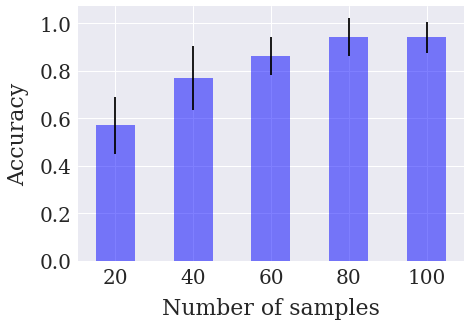

In [46]:
fig, ax = plt.subplots()
ax.bar(np.arange(20,120,20),np.mean(results,axis=1) , yerr=np.std(results,axis=1), align='center', alpha=0.5, ecolor='black', capsize=10,width=10,color='blue')
ax.set_ylabel('Accuracy',labelpad=10)
ax.set_xlabel('Number of samples',labelpad=10)
# ax.set_xticks(np.arange(20,120,5))
# ax.set_xticklabels(materials)
# ax.set_title('Accu')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('exp1.pdf')
plt.show()